# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.4:1.2:1.2:1.2:1.0:1.2:1.3:1.2:1.2
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.0:1.5:1.3:1.3:1.0:1.2:1.0:1.2:1.1:1.2
-------------------------------------
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       656 |     568 |     88 |
|  1 |       811 |     685 |    126 |
|  2 |       723 |     613 |    110 |
|  3 |       692 |     585 |    107 |
|  4 |       664 |     579 |     85 |
|  5 |       606 |     502 |    104 |
|  6 |       702 |     615 |     87 |
|  7 |       742 |     641 |    101 |
|  8 |       705 |     611 |     94 |
|  9 |       699 |     601 |     98 |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")
print(f"This can be seen in atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       9
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       0
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       8

Every row in the column contains the data of one image, with shape: (28, 28, 1)
This can be seen in atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 256}
Evaluation --> f1_weighted: 0.8383  Best f1_weighted: 0.8383
Time iteration: 4.567s   Total time: 4.571s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9531  Best f1_weighted: 0.9531
Time iteration: 13.686s   Total time: 18.261s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9650  Best f1_weighted: 0.9650
Time iteration: 12.343s   Total time: 30.608s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9482  Best f1_weighted: 0.9650
Time iteration: 13.413s   Total time: 44.025s
Initial point 5 ---------------------------------
Parameters --> {'

## Analyze the results

In [8]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[1.4897224e-06, 5.4117449e-10, 1.1748154e-07, ..., 1.2007180e-07,
        2.6463531e-04, 4.6529571e-08],
       [1.0000000e+00, 1.9961109e-14, 1.6526155e-08, ..., 3.4194327e-12,
        2.9235939e-10, 3.0539699e-10],
       [4.0663362e-12, 3.1200238e-15, 6.1781608e-11, ..., 1.0150671e-06,
        9.2449845e-08, 2.2268687e-06],
       ...,
       [2.3829648e-07, 8.3723112e-10, 8.3022382e-12, ..., 8.2501588e-09,
        8.3555416e-05, 7.2963485e-06],
       [1.6683378e-05, 8.7856176e-09, 1.1725149e-06, ..., 2.9677498e-09,
        1.9032645e-10, 1.6598709e-09],
       [1.3498024e-05, 2.3719608e-07, 1.5766896e-06, ..., 6.9231514e-06,
        9.9954671e-01, 1.0082934e-04]], dtype=float32)

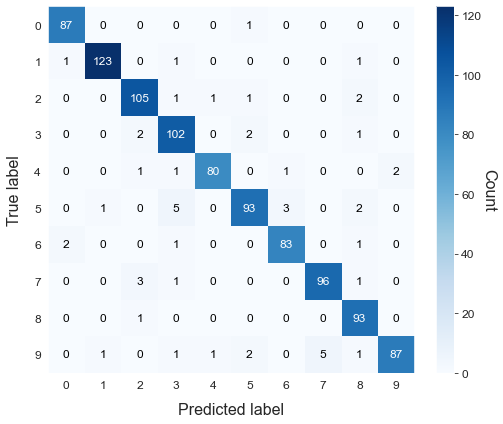

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()